# AutoML ValueChanging
## 1. setting modules

In [1]:
# load modules
import numpy as np
import pandas as pd
import tqdm
import random
import os

# split
from sklearn.model_selection import train_test_split

# models 
from xgboost import XGBRegressor, DMatrix
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from supervised.automl import AutoML

# tuning
import optuna

# vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# visualization
from matplotlib import pyplot as plt

# metrics
from sklearn.metrics import mean_squared_log_error

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# random seed 고정하기
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
# load data
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
add = pd.read_csv('../Data/another_factor.csv', encoding = 'cp949')

In [4]:
# 필요한 데이터만 가져오기
use_train = train[['사고일시', '기상상태', '노면상태', '사고유형', '시군구', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO']]
use_test = test[test.columns.difference(['ID'])]

## 2. data preprocessing

In [5]:
# 요일 월~금: 0 토~일:1
# use_train['주말'] = np.where(use_train['요일'].isin(['월요일', '화요일', '수요일', '목요일', '금요일']), 0, 1)
# use_test['주말'] = np.where(use_test['요일'].isin(['월요일', '화요일', '수요일', '목요일', '금요일']), 0, 1)

In [6]:
## date type data
use_train['사고일시'] = pd.to_datetime(use_train['사고일시'])
use_test['사고일시'] = pd.to_datetime(use_test['사고일시'])

# split year, month, day, hour
use_train['year'] = use_train['사고일시'].dt.year
use_train['month'] = use_train['사고일시'].dt.month
use_train['day'] = use_train['사고일시'].dt.day
use_train['hour'] = use_train['사고일시'].dt.hour

use_test['year'] = use_test['사고일시'].dt.year
use_test['month'] = use_test['사고일시'].dt.month
use_test['day'] = use_test['사고일시'].dt.day
use_test['hour'] = use_test['사고일시'].dt.hour

In [7]:
# 시간을 푸리에 변환
use_train['sin_hour'] = np.sin(2 * np.pi * use_train['hour']/23.0)
use_train['cos_hour'] = np.cos(2 * np.pi * use_train['hour']/23.0)
use_test['sin_hour'] = np.sin(2 * np.pi * use_test['hour']/23.0)
use_test['cos_hour'] = np.cos(2 * np.pi * use_test['hour']/23.0)

In [8]:
# 시군구 나누기
use_train[['시', '구', '동가']] = use_train['시군구'].str.split(' ', expand = True)
use_test[['시', '구', '동가']] = use_test['시군구'].str.split(' ', expand = True)

In [9]:
# 추가변수 붙여넣기
use_train2 = pd.merge(use_train, add, how = 'left', on = '동가')
use_test2 = pd.merge(use_test, add, how = 'left', on = '동가')

In [10]:
# 결측치는 0으로
use_train2[add.columns] = use_train2[add.columns].fillna(0)
use_test2[add.columns] = use_test2[add.columns].fillna(0)

In [11]:
use_train2.columns

Index(['사고일시', '기상상태', '노면상태', '사고유형', '시군구', '사망자수', '중상자수', '경상자수', '부상자수',
       'ECLO', 'year', 'month', 'day', 'hour', 'sin_hour', 'cos_hour', '시',
       '구', '동가', '보호구역', '불법주정차', '차량전용', '평지도로', '설치개수', '주차장개수',
       '어린이보호구역개수'],
      dtype='object')

In [12]:
# 각 변수 2분할
use_train2['맑음'] = np.where(use_train2['기상상태'] == '맑음', 1, 0)
use_test2['맑음'] = np.where(use_test2['기상상태'] == '맑음', 1, 0)

use_train2['건조한바닥'] = np.where(use_train2['노면상태'] == '건조', 1, 0)
use_test2['건조한바닥'] = np.where(use_test2['노면상태'] == '건조', 1, 0)

In [15]:
# 안쓰는 열 제외
use_train3 = use_train2.drop(['기상상태', '노면상태', '사고유형', '구', 'year', 'day', 'month',
                              'hour', '시', '동가', '사고일시', '시군구', '보호구역', '불법주정차', '차량전용', '평지도로', '주차장개수', '어린이보호구역개수'], axis = 1)

use_test3 = use_test2.drop(['기상상태', '노면상태', '사고유형', '구', 'year', 'day', 'month',
                              'hour', '시', '동가', '사고일시', '시군구', '보호구역', '불법주정차', '차량전용', '평지도로', '주차장개수', '어린이보호구역개수'], axis = 1)

In [89]:
# type 변경
#use_train4[use_train4.columns.difference(['sin_hour', 'cos_hour'])] = use_train4[use_train4.columns.difference(['sin_hour', 'cos_hour'])].astype('int64')
#use_test4[use_test4.columns.difference(['sin_hour', 'cos_hour'])] = use_test4[use_test4.columns.difference(['sin_hour', 'cos_hour'])].astype('int64')

## 3. Modeling

In [91]:
# train test split
x_train = use_train3[use_train3.columns.difference(['사망자수', '중상자수', '경상자수', '부상자수', 'ECLO'])]
y_train = use_train3['ECLO']

In [98]:
# automl modeling
automl = AutoML(mode="Compete",
                algorithms=["CatBoost",
                            "Xgboost",
                            "LightGBM",
                            ], 
                ml_task = "regression",
                eval_metric = 'rmse',
                random_state = 42,
                n_jobs = -1,
                total_time_limit=43200,
                results_path = '../Model/automl_value_decreased/',
                explain_level=2
               )

AutoML directory: ../Model/automl_basic/
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['CatBoost', 'Xgboost', 'LightGBM']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'mix_encoding', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree rmse 3.225348 trained in 24.95 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models


KeyboardInterrupt: 

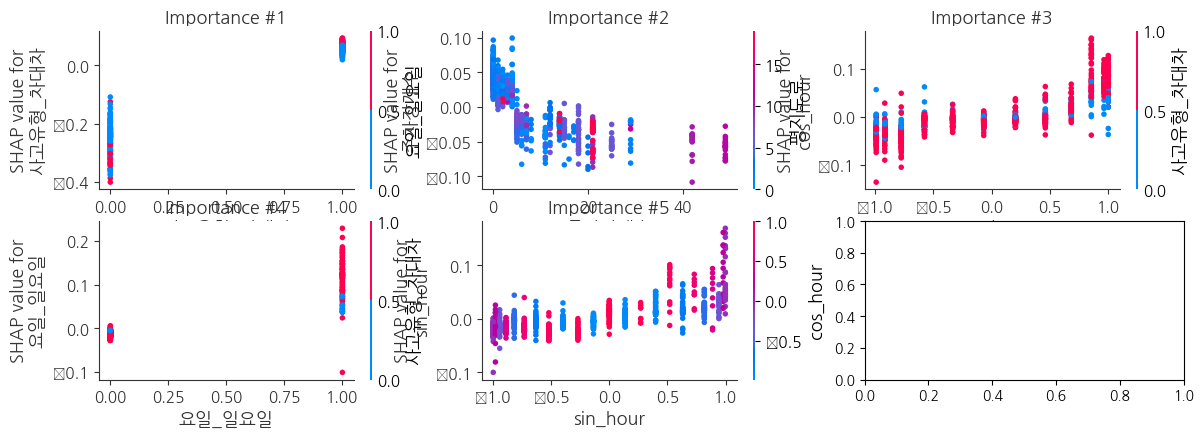

In [99]:
# fitting
automl.fit(x_train, y_train)

In [ ]:
preds = automl.predict(use_test3)

In [294]:
# submission 만들기
sample_submission = pd.read_csv('../Data/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = preds
baseline_submission.to_csv('../Data/AutoML_decrease_value.csv', index = False, encoding = 'cp949')